<a href="https://colab.research.google.com/github/RSeth-Creator/Data/blob/dataScience/NLP_S7_Classifier__Selection_BasedOn_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Evaluation matrices 
1.   Accuracy = (Predicted Correctly)/(Total No. of Observation)
2.   Precision = (Predicted spam that are actually spam)/(total predicted as spam)

1.   Recall = (Predicted as spam that are actually spam)/(Total that are actually spam)






Ensemble Techniques:

1.   Techniques that creates multiple models and then combines them to provide better results than any of the single model individually
2.   Aggregating the opinion of many rather than the isolated opinion of one 


1.   Random Forest : Ensemble learning method that constructts a collection of decision trees and the aggregates the predictions of each tree  to determine the final prediction. by the voting of the output list of all  the decesion tree we can predict the outcome . it can handle ordinal & continuous data  & can handle missing value & outlier, less likely to overfit






In [ ]:
#Mounting the drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## IMport required libraries

In [ ]:
import nltk
import pandas as pd 
import re 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import string 
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
ps=nltk.PorterStemmer()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Import data from fil

In [ ]:
data = pd.read_csv("drive/My Drive/SMSSpamCollection.tsv",sep = '\t', header = None)
data.columns = ['labels', 'body_text']
data.head()


,labels,body_text
0,ham,I've been searching for the right words to tha...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,ham,Even my brother is not like to speak with me. ...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!


## Create new feature (Number od character present in the string)

In [ ]:
# length of character = len(string)- count of white-spaces
data['body_len']=data['body_text'].apply(lambda x :len(x)-x.count(" "))


## Create new feature (% of punctuation present in the string)

In [ ]:

#Creating a function to fin dout the % of punctuation present in the text
def count_punct(text):
  count = sum([1 for char in text if char in string.punctuation])
  return round(count/(len(text) - text.count(" ")), 3)*100
    
data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))

data.head(2)

,labels,body_text,body_len,punct%
0,ham,I've been searching for the right words to tha...,160,2.5
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7


## Create a function to clean the text 

In [ ]:
def clean_text(text):
  text = "".join([word.lower() for word in text if word not in string.punctuation])#Punctuation removal
  tokens = re.split('\W+', text) #tokenize
  text = [ps.stem(word) for word in tokens if word not in stopwords] # Stopwords removal
  return text

## Apply the vectorizer in the text to find out the score 

In [ ]:
tfidf_vect  = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(data['body_text'])
#count_vect  = CountVectorizer(analyzer=clean_text)
#X_tfidf = count_vect.fit_transform(data['body_text'])

##  create the feature matrix kept the label seperate

In [ ]:
X_features = pd.concat([data['body_len'],data['punct%'],pd.DataFrame(X_tfidf.toarray())],axis= 1)

In [ ]:
X_features.head()

,body_len,punct%,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,8067,8068,8069,8070,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080,8081,8082,8083,8084,8085,8086,8087,8088,8089,8090,8091,8092,8093,8094,8095,8096,8097,8098,8099,8100,8101,8102,8103,8104,8105,8106
0,160,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,128,4.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,49,4.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28,7.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




1.   Precision: 1 ==>All mail in the spam folder is the spam
2.   Recall ==> 61.8% of all spam that has come to your mailwas properly placed into the spam folder 

1.  Accuracy: ==>  95% of emails that comes into your mail that correctly identified as spam






# Cross validation with multiple classifier (which will give the best average accuracy)

Importing the models 

In [ ]:
#Checking which classification model is giving best accuracy on top of the amazon data 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB 
from sklearn.model_selection import cross_val_score

*** Create a list with required model name ***

In [ ]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

** Assing the level of cross validation to find the best accuracy **


In [ ]:

CV = 10  #cross validation number here it os 5 
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_features, data['labels'], scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
cv_df.head(2)

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.867145
1,RandomForestClassifier,1,0.867145


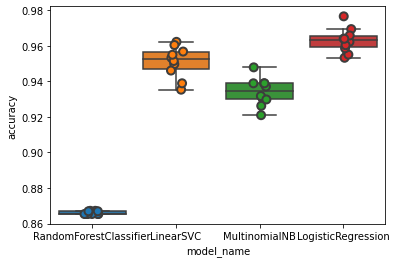

model_name
LinearSVC                 0.950972
LogisticRegression        0.963003
MultinomialNB             0.934085
RandomForestClassifier    0.866020
Name: accuracy, dtype: float64

In [ ]:
#Showing which model giving the best accuracy
import seaborn as sns
from matplotlib import pyplot as plt
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

#finding out the accuracy mean for all the classification model 
cv_df.groupby('model_name').accuracy.mean()

In [ ]:

#Applying SVC to the dataset as it has the highest accuracy
model_svc = LinearSVC()
X_train, X_test, y_train, y_test = train_test_split(X_features, data['labels'], 
                                                                                 test_size=0.33, random_state=0)
model_svc.fit(X_train, y_train)
y_pred = model_svc.predict(X_test)




/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat


array([[1574,    1],
       [ 225,   38]])

In [ ]:
precision, recall, fscore, support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Est: {} / Depth: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
           n_est, depth, round(precision, 3), round(recall, 3),
           round((y_pred==y_test).sum() / len(y_pred), 3)))

Est: 100 / Depth: None ---- Precision: 0.974 / Recall: 0.144 / Accuracy: 0.877
